# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from workspaceutils import keep_awake

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)


(891221, 85)
(85, 4)


In [5]:
# Look at the data a bit
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [6]:
# View the feature information
feat_info.head(3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


In [7]:
# Look at summary statistics for the data
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
# What are all the types of data
feat_info["type"].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [9]:
# What are all the information levels
feat_info["information_level"].unique()

array(['person', 'household', 'building', 'microcell_rr4', 'microcell_rr3',
       'postcode', 'region_rr1', 'macrocell_plz8', 'community'], dtype=object)

In [10]:
# How many (total) missing values are there
azdias.isnull().sum().sum()

4896838

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Define a function that converts the string of list to a list
def string_to_list(s):
    if len(s) > 2:
        L = [x for x in s[1:-1].split(",")]
        return [int(x) if x.lstrip('-').isnumeric() else x for x in L]
    else:
        return [""] # Awkward workaround due to pandas not being at the latest version

In [12]:
# Define a function that identifies how many naturally occuring missing/unknown values and how many are encoded
# Takes in a series, a missing values list, and a variable name and outputs a dictionary
def naturally_missing(sr, mvs):
    vcs = sr.value_counts()
    nat = sr.isnull().sum()
    enc = sum([vcs[a] for a in m if a in vcs.index])
    return {"NaN": nat, "Missing/Unknown": enc}

In [13]:
# Find the naturally missing/encoded missing amounts:
nan_info_dict = {}
for c in list(azdias):
    m = string_to_list(feat_info[feat_info["attribute"] == c]["missing_or_unknown"].values[0])
    nan_info_dict[c] = naturally_missing(azdias[c], m)

In [14]:
# Replace all missing/encoded values with NaN
cols = list(azdias)
for c in cols:
    m = string_to_list(feat_info[feat_info["attribute"] == c]["missing_or_unknown"].values[0])
    azdias[c].replace(m, np.NaN, inplace=True)

In [15]:
azdias.isnull().sum().sum()

8373929

In [16]:
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values = pd.DataFrame(nan_info_dict).transpose()
missing_values["Total"] = missing_values.sum(axis=1)
missing_values["Percent_Missing"] = missing_values["Total"]/len(azdias)
missing_values.head()

,Missing/Unknown,NaN,Total,Percent_Missing
AGER_TYP,685843,0,685843,0.769554
ALTERSKATEGORIE_GROB,2881,0,2881,0.003233
ANREDE_KZ,0,0,0,0.000000
CJT_GESAMTTYP,0,4854,4854,0.005446
FINANZ_MINIMALIST,0,0,0,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0e97a44e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc0e8f77400>]], dtype=object)

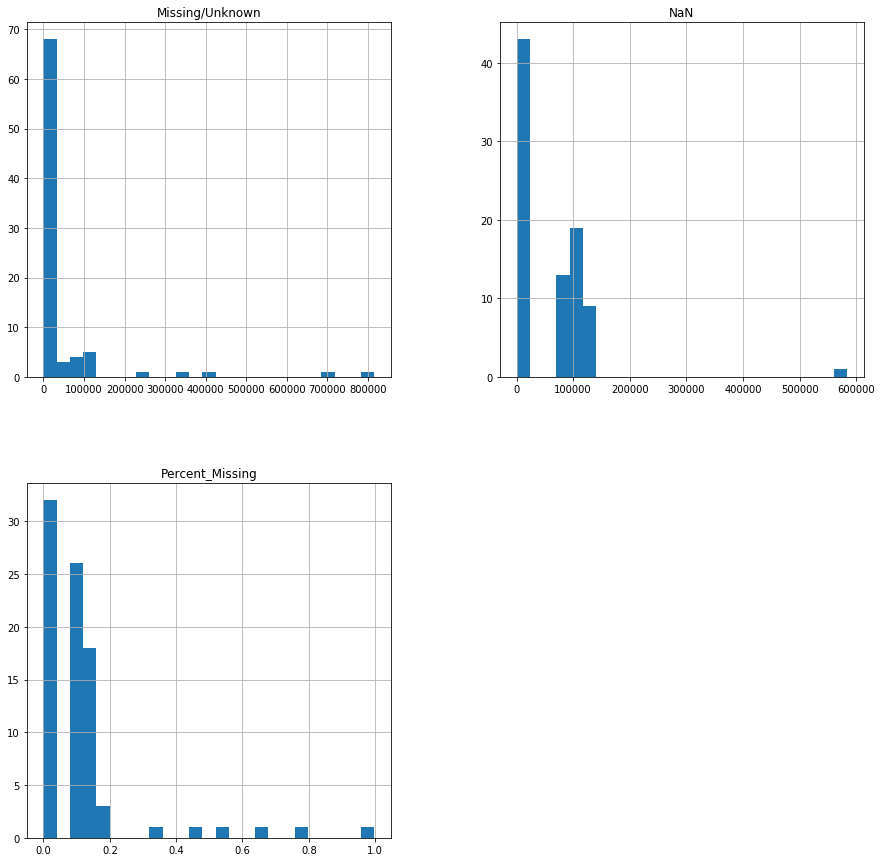

In [18]:
# Investigate patterns in the amount of missing data in each column.
missing_values[["Missing/Unknown", "NaN", "Percent_Missing"]].hist(bins=25, figsize=(15,15))


In [19]:
# How many categories have over a quarter of the data missing?
missing_values[missing_values["Percent_Missing"] > 0.25]

,Missing/Unknown,NaN,Total,Percent_Missing
AGER_TYP,685843,0,685843,0.769554
GEBURTSJAHR,392318,0,392318,0.440203
TITEL_KZ,815562,73499,889061,0.997576
ALTER_HH,236768,73499,310267,0.348137
KK_KUNDENTYP,0,584612,584612,0.655967
KBA05_BAUMAX,343200,133324,476524,0.534687


In [20]:
missings = list(missing_values[missing_values["Percent_Missing"] > 0.25].index)
feat_info[feat_info["attribute"].isin(missings)]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop([list(missing_values[missing_values["Percent_Missing"] > 0.25].index)][0], axis=1, inplace=True)
azdias.shape


(891221, 79)

In [22]:
azdias.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [23]:
# Drop the same categories from feature information
feat_info = feat_info[~feat_info["attribute"].isin([list(missing_values[missing_values["Percent_Missing"] > 0.25].index)][0])]


#### Discussion 1.1.2: Assess Missing Data in Each Column
I removed all columns that had more than 25% missing data. The missing values range from 34.8% to 99.8% missing values. From the histogram this seemed like a natural break point. There were six columns removed: `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP`, and `KBA05_BAUMAX`. Half of the types are categorical, but the others are not a uniform type. Thus it may be coincidence that three happen to be categorical. The same can be said for information level: half are person but the other three don't have a pattern. In addition, there is not a clear pattern with regards to what kind of missing data there is (natural NaNs vs encoded NaNs).


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

5035304 missing values left


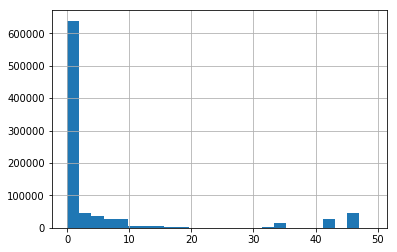

In [24]:
# How much data is missing in each row of the dataset?
print("{} missing values left".format(azdias.isnull().sum().sum()))
num_nans = azdias.isnull().sum(axis=1)
num_nans.hist(bins=25)

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def split_on_missing(df, miss=10):
    num_nans = df.isnull().sum(axis=1)
    cats = list(num_nans[num_nans <= miss].index)
    return df.iloc[cats], df.drop(cats)

# We'll split on p = 15% (11 missing values)
few, many = split_on_missing(azdias, 3)

In [26]:
few.shape

(684502, 79)

In [27]:
many.shape

(206719, 79)

In [28]:
many.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


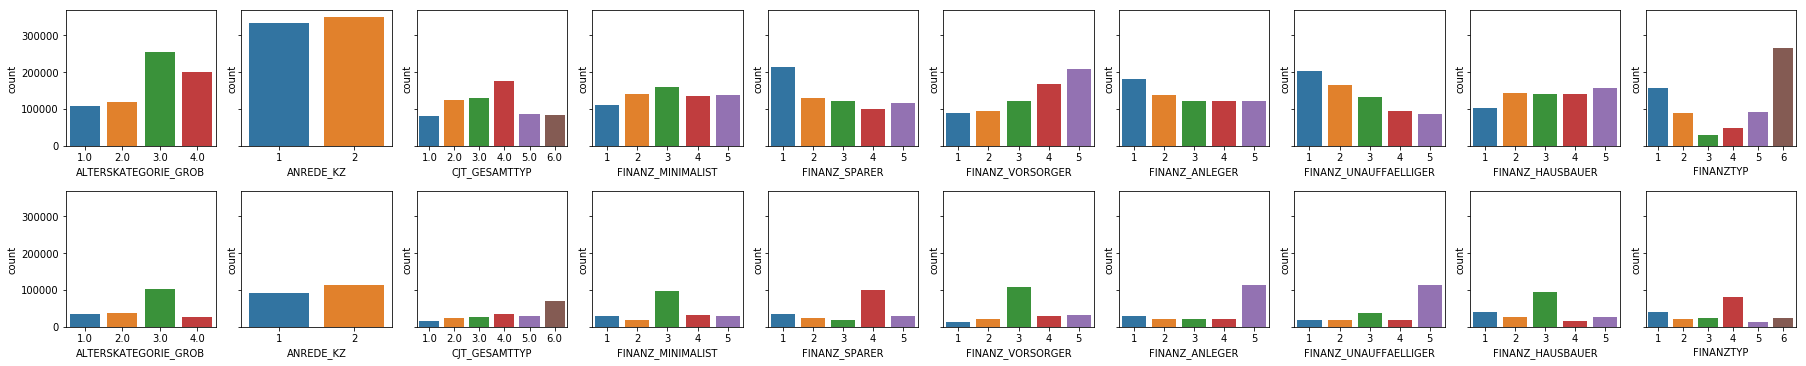

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
plot_cols = list(few)[:10] # Plot the first ten columns
f, axs = plt.subplots(2, 10, sharey=True, figsize=(25,5))
for i, e in enumerate(plot_cols):
    sns.countplot(few[e], ax=axs[0, i])
    sns.countplot(many[e], ax=axs[1, i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [30]:
# We don't want to use rows that have too much empty data, so I'll drop rows that have more than 15 empty values
azdias, _ = split_on_missing(azdias, 15)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I split the data based on those with less than or equal to three missing values. Then I plotted the first ten columns. The top row is the data with "few" missing values and the bottom row is that with "many".

In some of the columns examined, the data looks qualitatively different; often one category spikes in places where it doesn't in the other split. An example is `FINANZ_ANLEGER`. Some, however, does look qualitatively similar, having the same distribution, such as `ANREDE_KZ`.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
feat_info["type"].value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_data = azdias[feat_info[feat_info["type"] == "categorical"]["attribute"].values]


In [33]:
binary = []
multilevel = []
drop = []

drop_num = 10 # Drop those that have more than 10 categories
for c in list(cat_data):
    nuniq = cat_data[c].nunique()
    if nuniq == 2:
        binary.append(c)
    elif nuniq > drop_num:
        drop.append(c)
    else:
        multilevel.append(c)
    print("{} --> {} categories: {}".format(c, nuniq, list(cat_data[c].unique())))
    

ANREDE_KZ --> 2 categories: [2, 1]
CJT_GESAMTTYP --> 6 categories: [5.0, 3.0, 2.0, 4.0, 1.0, 6.0, nan]
FINANZTYP --> 6 categories: [1, 6, 5, 2, 4, 3]
GFK_URLAUBERTYP --> 12 categories: [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 2.0, 6.0, nan]
GREEN_AVANTGARDE --> 2 categories: [0, 1]
LP_FAMILIE_FEIN --> 11 categories: [5.0, 1.0, nan, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, 9.0, 3.0]
LP_FAMILIE_GROB --> 5 categories: [3.0, 1.0, nan, 5.0, 2.0, 4.0]
LP_STATUS_FEIN --> 10 categories: [2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 5.0, 8.0, 6.0, 7.0, nan]
LP_STATUS_GROB --> 5 categories: [1.0, 2.0, 4.0, 5.0, 3.0, nan]
NATIONALITAET_KZ --> 3 categories: [1.0, 3.0, 2.0, nan]
SHOPPER_TYP --> 4 categories: [3.0, 2.0, 1.0, 0.0, nan]
SOHO_KZ --> 2 categories: [1.0, 0.0]
VERS_TYP --> 2 categories: [2.0, 1.0, nan]
ZABEOTYP --> 6 categories: [5, 3, 4, 1, 6, 2]
GEBAEUDETYP --> 7 categories: [8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]
OST_WEST_KZ --> 2 categories: ['W', 'O']
CAMEO_DEUG_2015 --> 9 categories: ['8', '

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Create a new dataframe of categorical variables 
enc_df = pd.DataFrame()

# Add binary variables as is
enc_df[binary] = azdias[binary]

# If type is not numeric, one hot encode it
for col in list(enc_df):
    if not np.issubdtype(enc_df[col].dtype, np.number):
        enc_df = pd.concat([enc_df.drop(col, axis=1), pd.get_dummies(enc_df[col], prefix=col)], axis=1)

# One hot encode multilevel variables we decided to keep
MLDF = azdias[multilevel]
for col in list(MLDF):
    if MLDF[col].dtype == "int":
        enc_df = pd.concat([enc_df, pd.get_dummies(MLDF[col], prefix=col, dummy_na=True)], axis=1)
    else:
        # This awkward workaround since pandas is not at the latest version; there's no 999 in the data frame
        MM = MLDF[col].fillna(999)
        enc_df = pd.concat([enc_df, pd.get_dummies(MM.astype("int"), prefix=col)], axis=1)
        enc_df.rename({col+"_999": col+"_nan"}, inplace=True, axis='columns')
        

enc_df.head()


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ_O,OST_WEST_KZ_W,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan
1,2,0,1.0,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,1,0.0,1.0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,2,0,0.0,1.0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0.0,2.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,2,0,0.0,2.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features
There were 18 categorical data features. I kept all those with less than or equal to 10 categories. This was 15. For the one binary category that was not numerical, I used df.get_dummies() to simply one-hot encode it. Since Pandas is not at the latest version in this environment, I had to do some awkward workarounds regarding those features containing nans that needed one hot encoding. I had to fill them in with 999 (a number that does not appear in the data since I limited it to 10 categories) and then cast the data to integers (pandas version 0.24 lets you do this even if there are nans in the data). The 15 categorical variables became 77 fields.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

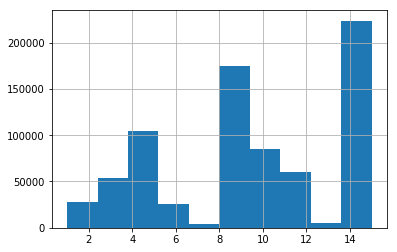

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].hist()

#### From Data_Dictionary.md:
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [36]:
def reverse_dict(d):
    new_d = {}
    for entry in d:
        for integer in d[entry]:
            new_d[integer] = entry
    return new_d

In [37]:
decades = {"40s": [1, 2], "50s": [3, 4], "60s": [5, 6, 7], "70s": [8, 9], "80s": [10, 11, 12, 13], "90s": [14, 15]}
movements = {"mainstream": [1, 3, 5, 8, 10, 12, 14], "avantgarde": [2, 4, 6, 7, 9, 11, 13, 15]}

decade_map = reverse_dict(decades)
movement_map = reverse_dict(movements)


In [38]:
decs = pd.get_dummies(azdias["PRAEGENDE_JUGENDJAHRE"].replace(decade_map), dummy_na=True, prefix="decade")
movs = pd.get_dummies(azdias["PRAEGENDE_JUGENDJAHRE"].replace(movement_map), dummy_na=True, prefix="movement")
enc_df = pd.concat([enc_df, decs, movs], axis=1)

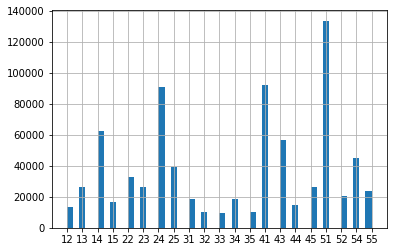

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].hist(bins=50)

In [40]:
# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits 
wealth = pd.get_dummies(azdias["CAMEO_INTL_2015"].apply(lambda x: np.floor(float(x)/10)), dummy_na=True, prefix="weath")
life_stage = pd.get_dummies(azdias["CAMEO_INTL_2015"].apply(lambda x: float(x)%10), dummy_na=True, prefix="life_stage")
enc_df = pd.concat([enc_df, wealth, life_stage], axis=1)


In [41]:
# What are all the mixed types
feat_info[feat_info["type"] == "mixed"]["attribute"].values

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'PLZ8_BAUMAX'], dtype=object)

#### LP_LEBENSPHASE_GROB: Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

In [42]:
age = {"younger": [1, 9, 11], "higher": [2, 10, 12], "not_spce": [3, 4, 5, 6, 7, 8]}
income = {"low/avg": [1, 2, 4, 7, 9, 10], "high": [3, 5, 8, 11, 12], "not_spec": [6]}
household = {"single": [1, 2, 3, 4, 5, 6, 7], "multiperson": [9, 10, 11, 12], "not_spec": [8]}
families = {"couple": [4, 5], "family": [7], "parents": [6], "not_spec": [1, 2, 3, 8, 9, 10, 11, 12]}
       
age_map = reverse_dict(age)
income_map = reverse_dict(income)
household_map = reverse_dict(household)
family_map = reverse_dict(families)

In [43]:
lplg = azdias["LP_LEBENSPHASE_GROB"]
ages = pd.get_dummies(lplg.replace(age_map), dummy_na=True, prefix="age")
incs = pd.get_dummies(lplg.replace(income_map), dummy_na=True, prefix="income")
hous = pd.get_dummies(lplg.replace(household_map), dummy_na=True, prefix="household")
fams = pd.get_dummies(lplg.replace(family_map), dummy_na=True, prefix="family")

enc_df = pd.concat([enc_df, ages, incs, hous, fams], axis=1)

In [44]:
# WOHNLAGE will be treated as a categorical variable
WL = azdias["WOHNLAGE"].fillna(999)
enc_df = pd.concat([enc_df, pd.get_dummies(WL.astype("int"), prefix="WOHNLAGE")], axis=1)
enc_df.rename({"WOHNLAGE_999": "WOHNLAGE_nan"}, inplace=True, axis='columns')

In [45]:
# PLZ8_BAUMAX will be treated as a categorical variable
PLZ = azdias["PLZ8_BAUMAX"].fillna(999)
enc_df = pd.concat([enc_df, pd.get_dummies(PLZ.astype("int"), prefix="PLZ8_BAUMAX")], axis=1)
enc_df.rename({"PLZ8_BAUMAX_999": "PLZ8_BAUMAX_nan"}, inplace=True, axis='columns')

#### Discussion 1.2.2: Engineer Mixed-Type Features
- `LP_LEBENSPHASE_FEIN` has too many values that are not easily broken up, thus it was dropped.
- `LP_LEBENSPHASE_GROB` was encoded by age, income, household, family.
- `WOHNLAGE` can be treated as a categorical variable, by my judgement.
- `PLZ8_BAUMAX` can also be treated as a categorical variable, by my judgement.

    The variables that I kept were one-hot encoded and added to the encoded variables dataframe `enc_df`

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# Make the final data frame containing all the features that will be used
num_df = azdias[feat_info[feat_info["type"] == "numeric"]["attribute"].values]
int_df = azdias[feat_info[feat_info["type"] == "interval"]["attribute"].values]
ord_df = azdias[feat_info[feat_info["type"] == "ordinal"]["attribute"].values]
data = pd.concat([enc_df, num_df, int_df, ord_df], axis=1)
data.head(3)

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ_O,OST_WEST_KZ_W,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,...,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,2,0,1.0,2.0,0,1,0,0,0,0,...,3.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0
2,2,1,0.0,1.0,0,1,0,0,1,0,...,2.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0
3,2,0,0.0,1.0,0,1,0,1,0,0,...,NaN,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """    
    # Drop any columns that we dropped in azdias
    df = df[list(azdias)]
    
    # Replace all missing/encoded values with NaN
    cols = list(df)
    for c in cols:
        m = string_to_list(feat_info[feat_info["attribute"] == c]["missing_or_unknown"].values[0])
        df[c].replace(m, np.NaN, inplace=True)
    
    # Remove rows with more than 15 missing values
    df, _ = split_on_missing(df, 15)
    
    
    # Handle categorical data
    cat_data = df[feat_info[feat_info["type"] == "categorical"]["attribute"].values]
    
    # Create a new dataframe of categorical variables 
    clean_df = pd.DataFrame()
    
    # Add binary variables as is
    clean_df[binary] = df[binary]
    
    # If type is not numeric, one hot encode it
    for col in list(clean_df):
        if not np.issubdtype(clean_df[col].dtype, np.number):
            clean_df = pd.concat([clean_df.drop(col, axis=1), pd.get_dummies(clean_df[col], prefix=col)], axis=1)
    
    # One hot encode multilevel variables we decided to keep
    MLDF = df[multilevel]
    for col in list(MLDF):
        if MLDF[col].dtype == "int":
            clean_df = pd.concat([clean_df, pd.get_dummies(MLDF[col], prefix=col, dummy_na=True)], axis=1)
        else:
            # This awkward workaround since pandas is not at the latest version; there's no 999 in the data frame
            MM = MLDF[col].fillna(999)
            clean_df = pd.concat([clean_df, pd.get_dummies(MM.astype("int"), prefix=col)], axis=1)
            clean_df.rename({col+"_999": col+"_nan"}, inplace=True, axis='columns')

            
    # Deal with mixed value data
    decs = pd.get_dummies(df["PRAEGENDE_JUGENDJAHRE"].replace(decade_map), dummy_na=True, prefix="decade")
    movs = pd.get_dummies(df["PRAEGENDE_JUGENDJAHRE"].replace(movement_map), dummy_na=True, prefix="movement")
    clean_df = pd.concat([clean_df, decs, movs], axis=1)
    
    wealth = pd.get_dummies(df["CAMEO_INTL_2015"].apply(lambda x: np.floor(float(x)/10)), dummy_na=True, prefix="weath")
    life_stage = pd.get_dummies(df["CAMEO_INTL_2015"].apply(lambda x: float(x)%10), dummy_na=True, prefix="life_stage")
    clean_df = pd.concat([clean_df, wealth, life_stage], axis=1)
    
    lplg = df["LP_LEBENSPHASE_GROB"]
    ages = pd.get_dummies(lplg.replace(age_map), dummy_na=True, prefix="age")
    incs = pd.get_dummies(lplg.replace(income_map), dummy_na=True, prefix="income")
    hous = pd.get_dummies(lplg.replace(household_map), dummy_na=True, prefix="household")
    fams = pd.get_dummies(lplg.replace(family_map), dummy_na=True, prefix="family")
    clean_df = pd.concat([clean_df, ages, incs, hous, fams], axis=1)
    
    WL = df["WOHNLAGE"].fillna(999)
    clean_df = pd.concat([clean_df, pd.get_dummies(WL.astype("int"), prefix="WOHNLAGE")], axis=1)
    clean_df.rename({"WOHNLAGE_999": "WOHNLAGE_nan"}, inplace=True, axis='columns')
    
    PLZ = df["PLZ8_BAUMAX"].fillna(999)
    clean_df = pd.concat([clean_df, pd.get_dummies(PLZ.astype("int"), prefix="PLZ8_BAUMAX")], axis=1)
    clean_df.rename({"PLZ8_BAUMAX_999": "PLZ8_BAUMAX_nan"}, inplace=True, axis='columns')

    
    # Make the final data frame to return 
    num_df = df[feat_info[feat_info["type"] == "numeric"]["attribute"].values]
    int_df = df[feat_info[feat_info["type"] == "interval"]["attribute"].values]
    ord_df = df[feat_info[feat_info["type"] == "ordinal"]["attribute"].values]
    clean_df = pd.concat([clean_df, num_df, int_df, ord_df], axis=1)
    
    # Return the cleaned dataframe.
    return clean_df



## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# Fill in missing values with value randomly selected from probability distribution of other data points
for col in list(data):
    num_missing = data[col].isnull().sum()
    if num_missing > 0: # Save on computation
        missing_ind = data[col][data[col].isnull()].index.tolist() # Get indices of missing values
        val_cts = data[col].value_counts(normalize=True) # Get distribution of each value
        filler = np.random.choice(val_cts.index, num_missing, p=val_cts.values) # Randomly generate fillers
        data[col].fillna(pd.Series(filler, missing_ind), inplace=True)

In [49]:
data.isnull().sum().sum()

0

In [50]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler().fit(data)
scaled_df = scaler.transform(data)


### Discussion 2.1: Apply Feature Scaling
Instead of imputing the mean or the mode, I decided to imput values randomly chosen from the probability distribution of each column. That way, the distribution of data is preserved. I then used a standard scaler to scale the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(scaled_df)

Text(0.5,1,'Explained Variance Per Principal Component')

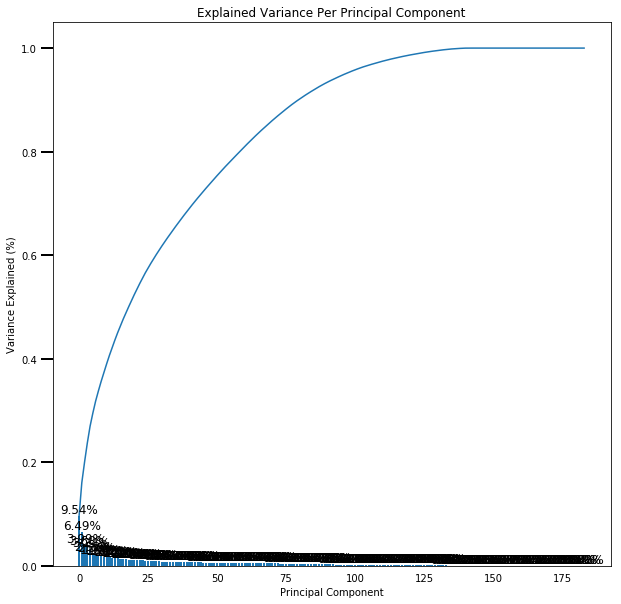

In [52]:
# Investigate the variance accounted for by each principal component.
# Create a plot like those in the labs
nc = len(pca.explained_variance_ratio_)
ind = np.arange(nc)
vals = pca.explained_variance_ratio_

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.bar(ind, vals)
ax.plot(ind, np.cumsum(vals))
for i in range(nc):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')


In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(75).fit(scaled_df)
X_pca = pca.transform(scaled_df)

In [54]:
sum(pca.explained_variance_ratio_)

0.87717584637056822

### Discussion 2.2: Perform Dimensionality Reduction
Roughly looking at the scree plot, I decided to keep 75 components since that looked like it would explain about 90% of the variability and cuts the number of fields to about 40% of the full data. I calculated the actual variability explained and it is about 88%.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Define a function that maps weights of the ith principal component and prints the lined values sorted by weight
def pca_weight(pca, cols, pc=1):
    comps = pca.components_[pc-1]
    wts = pd.Series(comps, cols)
    print(wts.sort_values().head(10))
    print("...\n...")
    print(wts.sort_values().tail(10))
cols = list(data)

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight(pca, cols, 1)


MOBI_REGIO          -0.187113
FINANZ_MINIMALIST   -0.181695
income_high         -0.176805
KBA05_ANTG1         -0.175424
PLZ8_ANTG1          -0.171114
KBA05_GBZ           -0.166459
PLZ8_BAUMAX_1       -0.162918
KONSUMNAEHE         -0.127551
PLZ8_GBZ            -0.126123
INNENSTADT          -0.120154
dtype: float64
...
...
life_stage_1.0        0.128850
weath_5.0             0.139993
EWDICHTE              0.144940
FINANZ_HAUSBAUER      0.146099
ORTSGR_KLS9           0.146570
income_low/avg        0.157796
PLZ8_ANTG4            0.165242
PLZ8_ANTG3            0.170806
HH_EINKOMMEN_SCORE    0.173825
LP_STATUS_GROB_1      0.185229
dtype: float64


In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight(pca, cols, 2)


FINANZ_SPARER           -0.225504
FINANZ_UNAUFFAELLIGER   -0.215283
SEMIO_REL               -0.206915
SEMIO_TRADV             -0.201992
decade_90s              -0.201885
FINANZ_ANLEGER          -0.201022
SEMIO_PFLICHT           -0.200028
SEMIO_RAT               -0.165867
age_younger             -0.162265
SEMIO_KULT              -0.154747
dtype: float64
...
...
CJT_GESAMTTYP_2         0.102224
W_KEIT_KIND_HH          0.110402
decade_60s              0.112998
RETOURTYP_BK_S          0.154156
SEMIO_LUST              0.156294
age_higher              0.163402
SEMIO_ERL               0.171428
ZABEOTYP_3.0            0.193519
FINANZ_VORSORGER        0.217349
ALTERSKATEGORIE_GROB    0.226491
dtype: float64


In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight(pca, cols, 3)


SEMIO_VERT           -0.237943
SEMIO_SOZ            -0.197376
SEMIO_KULT           -0.186469
SEMIO_FAM            -0.179296
family_not_spec      -0.139092
FINANZ_MINIMALIST    -0.101536
SHOPPER_TYP_0        -0.095935
FINANZTYP_5.0        -0.093022
ZABEOTYP_1.0         -0.083790
NATIONALITAET_KZ_1   -0.072006
dtype: float64
...
...
SHOPPER_TYP_nan    0.163595
SEMIO_ERL          0.168187
SEMIO_DOM          0.185013
SEMIO_KRIT         0.187962
SEMIO_KAEM         0.218880
age_nan            0.233920
family_nan         0.233920
household_nan      0.233920
income_nan         0.233920
ANREDE_KZ          0.247406
dtype: float64


### Discussion 2.3: Interpret Principal Components
For the first principal component, the most negative weight is for `MOBI_REGIO` (movement patterns - high to low) and the most positive weight is for `LP_STATUS_GROB_1` (social status, low-income earners). Low income people might have less mobility than wealthier people. 

For the second principal component, the most negative weight is for `FINANZ_SPARER` (money-saver type - high to low) and the most positive weight is for `ALTERSKATEGORIE_GROB` (estimated age group - young to old). This makes sense that the older you are, the more you save and vice versa.

For the third principal component, the most negative weight is for `SEMIO_VERT` (dreamful personality - high to low) and the most positive weight is for `ANREDE_KZ` (gender). One gender might have a more dreamful personality than the other. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
# Loop ver a number of different cluster counts
centers = []
scores = []

total_n = 30
for n in keep_awake(range(2, total_n+1)):
    kmeans = KMeans(n_clusters=n)
    model = kmeans.fit(X_pca)
    score = np.abs(model.score(X_pca))
    centers.append(n)
    scores.append(score)  
    print("Cluster {}: {:.3f}".format(n, scores[-1]))

Cluster 2: 115891131.086
Cluster 3: 110665512.100
Cluster 4: 107382424.139
Cluster 5: 103063231.534
Cluster 6: 100590526.604
Cluster 7: 98958573.412
Cluster 8: 97343839.835
Cluster 9: 95122365.188
Cluster 10: 93588459.226
Cluster 11: 92542464.970
Cluster 12: 90957302.027
Cluster 13: 89073321.254
Cluster 14: 88659467.773
Cluster 15: 87277765.869
Cluster 16: 84974562.454
Cluster 17: 84842683.952
Cluster 18: 83651076.728
Cluster 19: 84131273.579
Cluster 20: 82821564.666
Cluster 21: 81475973.847
Cluster 22: 80729326.306
Cluster 23: 79829785.527
Cluster 24: 79671905.835
Cluster 25: 78911092.019
Cluster 26: 78895319.479
Cluster 27: 77837241.252
Cluster 28: 77390190.596
Cluster 29: 76924781.772
Cluster 30: 76493743.071


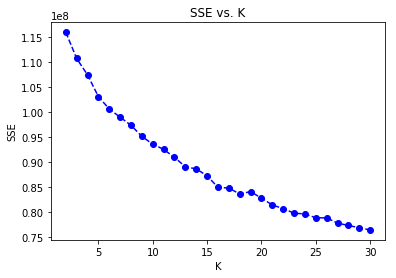

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# A plot like the one in lab; look for the elbow
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
num_clust = 17
kmeans = KMeans(n_clusters=num_clust)
model = kmeans.fit(X_pca)
preds = model.predict(X_pca)
clust_cent = model.cluster_centers_

(array([ 28111.,  27067.,  52549.,  88091.,  64520.,  98690.,  68074.,
         89505.,   3297.,  26421.,  17800.,  76981.,  37160.,   4300.,
         56054.,   4368.,  49299.]),
 array([  0.        ,   0.94117647,   1.88235294,   2.82352941,
          3.76470588,   4.70588235,   5.64705882,   6.58823529,
          7.52941176,   8.47058824,   9.41176471,  10.35294118,
         11.29411765,  12.23529412,  13.17647059,  14.11764706,
         15.05882353,  16.        ]),
 <a list of 17 Patch objects>)

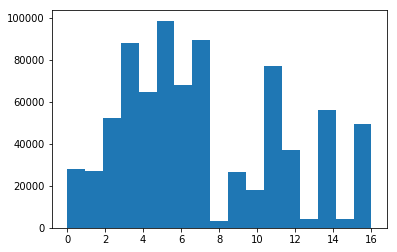

In [63]:
plt.hist(preds, bins=num_clust)

### Discussion 3.1: Apply Clustering to General Population
I plotted the number of clusters from n=2 to n=30. There is not a clear elbow in the plot; it continually keeps decreasing. I chose 17 clusters since after that there seems to be a linear decrease instead of an exponential-like curve.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_cus = clean_data(customers)

for col in list(clean_cus):
    num_missing = clean_cus[col].isnull().sum()
    if num_missing > 0: 
        missing_ind = clean_cus[col][clean_cus[col].isnull()].index.tolist() 
        val_cts = clean_cus[col].value_counts(normalize=True) 
        filler = np.random.choice(val_cts.index, num_missing, p=val_cts.values) 
        clean_cus[col].fillna(pd.Series(filler, missing_ind), inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [66]:
needed = [col for col in list(data) if col not in list(clean_cus)]
for n in needed:
    clean_cus[n] = [0]*len(clean_cus)

In [67]:
scale_cus = scaler.transform(clean_cus)
pca_cus = pca.transform(scale_cus)

In [68]:
cus_clust = model.predict(pca_cus)

In [69]:
# Look at frequency of clusters for customer data
Counter(cus_clust)

Counter({8: 140898})

It looks as if the model predicted all the customers into the same cluster

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

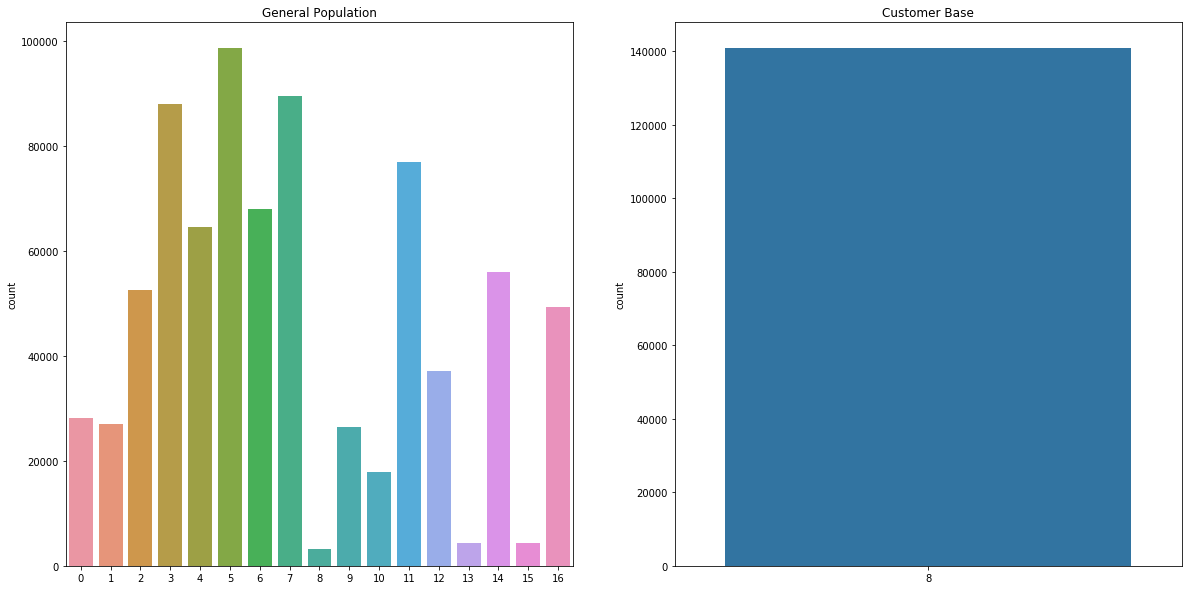

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
f, (a1, a2) = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(preds, ax=a1)
sns.countplot(cus_clust, ax=a2)
a1.title.set_text("General Population")
a2.title.set_text("Customer Base")

In [71]:
cust_props = {k: v/len(cus_clust) for k, v in Counter(cus_clust).items()}
pop_props = {k: v/len(preds) for k, v in Counter(preds).items()}

In [72]:
proportions = pd.DataFrame([cust_props, pop_props], index=["customers", "population"]).fillna(0)
proportions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
customers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
population,0.035481,0.034163,0.066326,0.111186,0.081435,0.124563,0.085921,0.11297,0.004161,0.033348,0.022467,0.097163,0.046902,0.005427,0.07075,0.005513,0.062224


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0d128abe0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc0d1254438>], dtype=object)

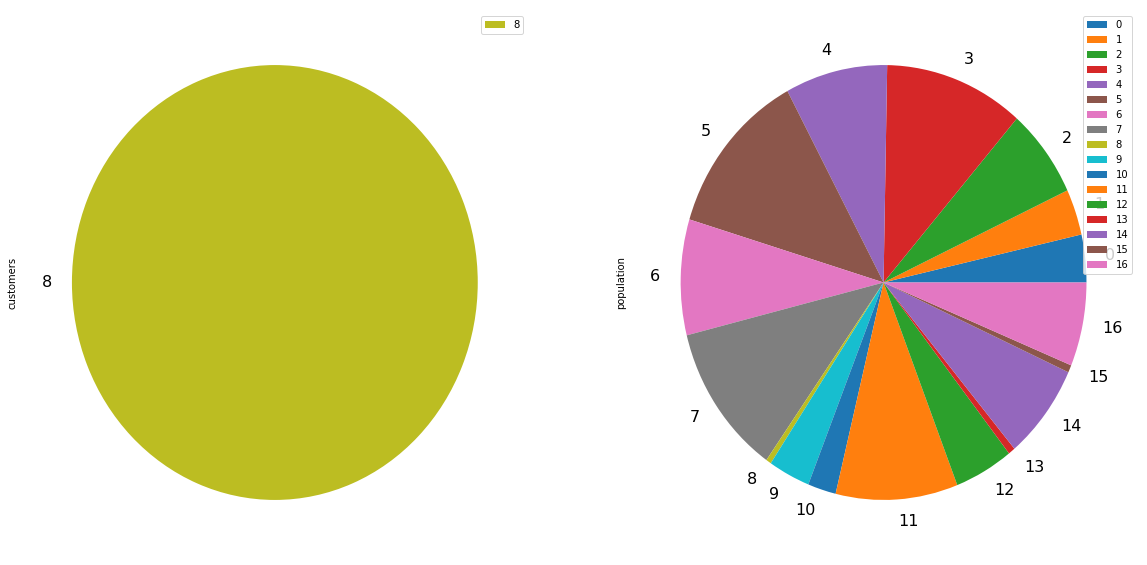

In [73]:
proportions.transpose().plot(kind="pie", subplots=True, figsize=(20,10), fontsize=16)

Text(0,0.5,'Proportion of Population')

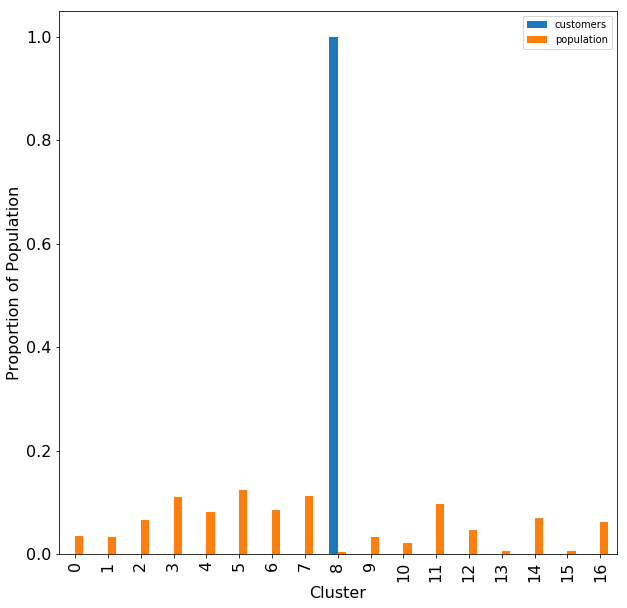

In [74]:
a = proportions.transpose().plot(kind="bar", figsize=(10,10), fontsize=16)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Proportion of Population", fontsize=16)

In [78]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# There are only customers in cluster 8
# Look at what kind of people are in cluster 8
c8 = clust_cent[8]
acp = pca.inverse_transform(c8)
unsc = scaler.inverse_transform(acp)
df8 = pd.DataFrame({list(data)[i]: e for i, e in enumerate(unsc)}, index=["cluster 8"])

In [79]:
list(df8)

['ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'VERS_TYP',
 'OST_WEST_KZ_O',
 'OST_WEST_KZ_W',
 'CJT_GESAMTTYP_1',
 'CJT_GESAMTTYP_2',
 'CJT_GESAMTTYP_3',
 'CJT_GESAMTTYP_4',
 'CJT_GESAMTTYP_5',
 'CJT_GESAMTTYP_6',
 'CJT_GESAMTTYP_nan',
 'FINANZTYP_1.0',
 'FINANZTYP_2.0',
 'FINANZTYP_3.0',
 'FINANZTYP_4.0',
 'FINANZTYP_5.0',
 'FINANZTYP_6.0',
 'FINANZTYP_nan',
 'LP_FAMILIE_GROB_1',
 'LP_FAMILIE_GROB_2',
 'LP_FAMILIE_GROB_3',
 'LP_FAMILIE_GROB_4',
 'LP_FAMILIE_GROB_5',
 'LP_FAMILIE_GROB_nan',
 'LP_STATUS_FEIN_1',
 'LP_STATUS_FEIN_2',
 'LP_STATUS_FEIN_3',
 'LP_STATUS_FEIN_4',
 'LP_STATUS_FEIN_5',
 'LP_STATUS_FEIN_6',
 'LP_STATUS_FEIN_7',
 'LP_STATUS_FEIN_8',
 'LP_STATUS_FEIN_9',
 'LP_STATUS_FEIN_10',
 'LP_STATUS_FEIN_nan',
 'LP_STATUS_GROB_1',
 'LP_STATUS_GROB_2',
 'LP_STATUS_GROB_3',
 'LP_STATUS_GROB_4',
 'LP_STATUS_GROB_5',
 'LP_STATUS_GROB_nan',
 'NATIONALITAET_KZ_1',
 'NATIONALITAET_KZ_2',
 'NATIONALITAET_KZ_3',
 'NATIONALITAET_KZ_nan',
 'SHOPPER_TYP_0',
 'SHOPPER_TYP_1',
 'SHOPPER_

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Look at cluster 15 and cluster 
# Wealth:
wealth_col = [col for col in df8 if col.startswith('weath')] # Looks like I mispelled wealth above
df8[wealth_col]

,weath_1.0,weath_2.0,weath_3.0,weath_4.0,weath_5.0,weath_nan
cluster 8,0.312957,0.145234,0.156785,0.226465,0.158267,0.00029


In [84]:
# Income
inc_col = [col for col in df8 if col.startswith('income')]
df8[inc_col]

,income_high,income_low/avg,income_not_spec,income_nan
cluster 8,0.956558,0.015683,0.007814,0.019946


In [83]:
# Life Stage
life_col = [col for col in df8 if col.startswith('life_stage')]
df8[life_col]

,life_stage_1.0,life_stage_2.0,life_stage_3.0,life_stage_4.0,life_stage_5.0,life_stage_nan
cluster 8,0.181691,0.074467,0.138028,0.396194,0.209329,0.00029


In [85]:
# Decade
dec_col = [col for col in df8 if col.startswith('decade')]
df8[dec_col]

,decade_40s,decade_50s,decade_60s,decade_70s,decade_80s,decade_90s,decade_nan
cluster 8,0.04533,0.138246,0.200078,0.343676,0.095449,0.114977,0.062245


In [86]:
# Movement
mov_col = [col for col in df8 if col.startswith('movement')]
df8[mov_col]

,movement_avantgarde,movement_mainstream,movement_nan
cluster 8,0.716528,0.221227,0.062245


In [88]:
# Age
age_col = [col for col in df8 if col.startswith('age')]
df8[age_col]

,age_higher,age_not_spce,age_younger,age_nan
cluster 8,0.316367,0.590193,0.073494,0.019946


In [89]:
# Household type
house_col = [col for col in df8 if col.startswith('household')]
df8[house_col]

,household_multiperson,household_not_spec,household_single,household_nan
cluster 8,0.33827,0.015523,0.626261,0.019946


In [94]:
# Gender
gen_col = [col for col in df8 if col.startswith('ANREDE_KZ')]
df8[gen_col]

,ANREDE_KZ
cluster 8,1.467466


In [95]:
# Consumer journey typography
cons_col = [col for col in df8 if col.startswith('CJT_GESAMTTYP')]
df8[cons_col]

,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,CJT_GESAMTTYP_nan
cluster 8,0.132745,0.161386,0.239738,0.232483,0.084368,0.148425,0.000856


In [96]:
# Most descriptive financial type
fin_col = [col for col in df8 if col.startswith('FINANZTYP')]
df8[fin_col]

,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,FINANZTYP_nan
cluster 8,0.081669,0.12868,0.079512,0.119103,0.342575,0.248461,3.051493e-16


In [97]:
# Religious
rel_col = [col for col in df8 if col.startswith('SEMIO_REL')]
df8[rel_col]

,SEMIO_REL
cluster 8,3.544911


In [98]:
# Traditional minded
trad_col = [col for col in df8 if col.startswith('SEMIO_TRADV')]
df8[trad_col]

,SEMIO_TRADV
cluster 8,3.329796


In [99]:
# Materialistic
mat_col = [col for col in df8 if col.startswith('SEMIO_MAT')]
df8[mat_col]

,SEMIO_MAT
cluster 8,3.891782


In [100]:
# Family-minded
fam_col = [col for col in df8 if col.startswith('SEMIO_FAM')]
df8[fam_col]

,SEMIO_FAM
cluster 8,3.986348


In [101]:
# Distance to point of sale
dis_col = [col for col in df8 if col.startswith('KONSUMNAEHE')]
df8[dis_col]

,KONSUMNAEHE
cluster 8,2.101108


In [102]:
# Distance to downtown
downtown_col = [col for col in df8 if col.startswith('INNENSTADT')]
df8[downtown_col]

,INNENSTADT
cluster 8,4.561875


In [103]:
# Size of community
comm_col = [col for col in df8 if col.startswith('ORTSGR_KLS9')]
df8[comm_col]

,ORTSGR_KLS9
cluster 8,5.901475


In [117]:
# Look at all these things for cluster 5, which is the largest cluster in the general population, 
# but which has none of the consumers
c5 = clust_cent[5]
acp5 = pca.inverse_transform(c5)
unsc5 = scaler.inverse_transform(acp5)
df5 = pd.DataFrame({list(data)[i]: e for i, e in enumerate(unsc5)}, index=["cluster 5"])

In [118]:
look_cols = [wealth_col, inc_col, life_col, dec_col, mov_col, age_col, house_col, gen_col, cons_col, \
            fin_col, rel_col, trad_col, mat_col, fam_col, dis_col, downtown_col, comm_col]
for c in look_cols:
    print(df5[c].round(3), "\n")

           weath_1.0  weath_2.0  weath_3.0  weath_4.0  weath_5.0  weath_nan
cluster 5      0.049      0.116      0.084      0.309      0.442        0.0 

           income_high  income_low/avg  income_not_spec  income_nan
cluster 5        0.025           0.974            0.001       0.001 

           life_stage_1.0  life_stage_2.0  life_stage_3.0  life_stage_4.0  \
cluster 5           0.402           0.051           0.091           0.247   

           life_stage_5.0  life_stage_nan  
cluster 5           0.209             0.0   

           decade_40s  decade_50s  decade_60s  decade_70s  decade_80s  \
cluster 5       0.074       0.177       0.247       0.381       0.075   

           decade_90s  decade_nan  
cluster 5       0.001       0.045   

           movement_avantgarde  movement_mainstream  movement_nan
cluster 5                0.062                0.893         0.045 

           age_higher  age_not_spce  age_younger  age_nan
cluster 5       0.857         0.049        0.093  

### Discussion 3.3: Compare Customer Data to Demographics Data
The customer data only fell into only one cluster: cluster 8. Interestingly, this is the smallest cluster of the 17 cluster in the general population. 

Let's look at some of the characteristics of cluster 8:
- Decent spread of 'wealth', with most of the people falling into the "wealthy" category. 
- Overwhelmingly high income - over 95% in this cluster are considered high income. 
- Mix of life stages, tending toward the higher life stages (i.e. older people)
- The most common decades are the 60s and 70s. 
- Nearly a third of the people are of the avantgarde movement. 
- Most of the ages are either 'higher' or 'not specified'. 
- Most of the households are single-family households. 
- Gender divide is just about even, leaning a bit toward males. 
- The Consumer journey typography is split between 3 and 4: advertising interested (not enthusiests nor minimalist). - Consumers would most describe themselves as investors. 
- Average to high amounds of religious affiliation. 
- Average to high traditional minded. 
- Highly materialistic and highly family-minded. 
- Tend to be inside of a 250 x 250m grid cell of point of sale (so close to the shopping). 
- Distance to downtown is 5-20 km
- Usually living in communities with a population of 20,000-100,000

Looking at cluster 5, which is the largest of the general population, we see:
- Mostly "poor" and "less affluent" people
- mostly average/low income
- Mostly Pre-Family Couples & Singles
- Most common decade is the 70s
- Almost 90% in the aventgarde movement
- Most of the ages are 'higher'
- Mostly single-family households 
- Gender is almost all females 
- Customers are advertising minimalists
- Consumers would most describe themselves as inconspicuous or money-savers.
- Very highly religious
- Highly traditional minded, materialistic, and family minded
- Tend to be inside of a 500 x 500m grid cell of point of sale
- Distance to downtown is 1-5 km
- Usually living in communities with a population of 50,000-100,000

So in short, the company should mail to rich, old people who like investing and should not mail to less affluent young females.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.